## Introduction to RNNs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from torch.utils.data.dataset import TensorDataset



# the "problem"

so far we dealt with tasks where the input and output had the same "shape" in every sample

but what if the input and/or output don't have a constant shape?

## you can use an RNN

### what is an RNN?

"recurrent" refers to the fact that we use some internal NN multiple times to process the input


let's define a simple neural network that takes an input of 2 numbers, and outputs one number,
this is something you already know how to build.

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        input_size = 2
        hidden_size = 10
        output_size = 1
        
        self.layer1 = nn.Linear(input_size,hidden_size)
        self.layer2 = nn.Linear(hidden_size,output_size)
        self.activation1 = nn.ReLU()
        
    def forward(self,x):
        
        out = self.layer1(x)
        out = self.activation1(out)
        out = self.layer2(out)
        
        return out

## now we can define a network that will handle variable size input by using this basic network we created as a building block

notice the loop where we use the "internal" network multiple times

In [3]:
class BasicRNN(nn.Module):
    def __init__(self):
        super(BasicRNN,self).__init__()
        
        self.internal_net = Net()
        
        
    def forward(self,x):
        
        sequence_length = len(x)
        outputs = []
        
        for i in range(sequence_length):
    
            output_i = self.internal_net(x[i])
            outputs.append(output_i)
        
        return torch.cat(outputs)

In [4]:
#here its processing input of length 3
x = torch.FloatTensor([[0.8,0.2],[0.42,0.1],[0.9,-0.3]])

basicRNN = BasicRNN()

basicRNN(x)

tensor([-0.2715, -0.2733, -0.2385], grad_fn=<CatBackward>)

In [5]:
#here its processing input of length 5
x = torch.FloatTensor([[0.8,0.2],[0.42,0.1],[0.9,-0.3],[0.2,0.1],[0.8,-0.3]])

basicRNN = BasicRNN()

basicRNN(x)

tensor([0.1538, 0.1156, 0.1395, 0.0954, 0.1332], grad_fn=<CatBackward>)

## as you saw in the lecture, there is a lot more internal structure to an RNN, but we don't actually have to code any of it, we can use the build in pytorch layers

In [571]:
hidden_state_size = 5
size_of_sequence_element = 2

lstm = nn.LSTM(size_of_sequence_element,hidden_state_size,batch_first=True)

x = torch.FloatTensor([[[0.8,0.2],[0.42,0.1],[0.9,-0.3],[0.2,0.1]]])

lstm(x)

(tensor([[[-0.1105, -0.0385, -0.0528, -0.0420,  0.0740],
          [-0.1116, -0.0722, -0.1120, -0.0364,  0.0757],
          [-0.1201, -0.0872, -0.1311, -0.0248,  0.1224],
          [-0.1022, -0.1099, -0.1751, -0.0171,  0.0730]]],
        grad_fn=<TransposeBackward0>),
 (tensor([[[-0.1022, -0.1099, -0.1751, -0.0171,  0.0730]]],
         grad_fn=<StackBackward>),
  tensor([[[-0.2327, -0.1823, -0.4966, -0.0322,  0.2120]]],
         grad_fn=<StackBackward>)))

## look at the output for an LSTM layer, it has three parts

1. the hidden state for every step in the sequence
2. the layer hidden state in the sequence (in principle this encodes the information from the whole sequence)
3. the cell state after the last entry in the sequence (forget about this for now, not important)

## so we can build a NN with this layer, and we are done?

In [7]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        
        size_of_sequence_element = 2
        hidden_state_size = 5
        self.lstm = nn.LSTM(size_of_sequence_element,hidden_state_size,batch_first=True)
        
        output_size = 2
        self.linear = nn.Linear(hidden_state_size,output_size)
        
    def forward(self,x):
        
        hidden_states, (final_hidden_state, cell_state) = self.lstm(x)
        output = self.linear(final_hidden_state)
        
        return output
    
rnn = RNN()

x = torch.FloatTensor([[[0.8,0.2],[0.42,0.1],[0.9,-0.3],[0.2,0.1],[0.8,-0.3]]])

rnn(x)

tensor([[[-0.0747, -0.3515]]], grad_fn=<AddBackward0>)

## we need to worry about batches

there is one crtical issue with an RNN and all "irregular" inputs to neural networks.
when we train a NN, we use mini-batches. how do we deal with variable size input in batches?

each ML framework will have it's own style to deal with it. it also depends on the dataset.

this is the pytorch solution:

In [8]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

my_sequences = [
    torch.FloatTensor([[1],[2],[3],[4],[5]]),
    torch.FloatTensor([[1],[2],[3]]),
    torch.FloatTensor([[1],[2],[3],[4],[5],[6]])
]

sequence_lengths = [len(x) for x in my_sequences]
# sequence_lengths = [5, 3, 6]

#zero pad you sequences to the length of the largest sequence
max_length = np.max(sequence_lengths)
n_sequences = len(my_sequences)
sequence_tensor = torch.zeros((n_sequences,max_length,1)).float()
for i, (seq,seq_len) in enumerate( zip(my_sequences,sequence_lengths) ):
    sequence_tensor[i,:seq_len] = seq
# this gives:
# tensor([[1., 2., 3., 4., 5., 0.],
#        [1., 2., 3., 0., 0., 0.],
#        [1., 2., 3., 4., 5., 6.]])

#sort the sequences largest to smallest
sequence_lengths = torch.LongTensor(sequence_lengths)
sequence_lengths, perm_index = sequence_lengths.sort(0, descending=True)
sequence_tensor = sequence_tensor[perm_index]

# sequence_lengths = tensor([6, 5, 3])
# tensor([[1., 2., 3., 4., 5., 6.],
#        [1., 2., 3., 4., 5., 0.],
#        [1., 2., 3., 0., 0., 0.]])


packed_input = pack_padded_sequence(sequence_tensor,sequence_lengths.data.numpy(),batch_first=True)

size_of_sequence_element = 1
hidden_state_size = 5
lstm = nn.LSTM(size_of_sequence_element,hidden_state_size,batch_first=True)

hidden_states, (final_hidden_state, cell_state) = lstm(packed_input)

final_hidden_state

tensor([[[0.1274, 0.0638, 0.8958, 0.1110, 0.2690],
         [0.1467, 0.0793, 0.8446, 0.1306, 0.2658],
         [0.1689, 0.0832, 0.6264, 0.1278, 0.1842]]], grad_fn=<StackBackward>)

## lets demonstrate this with the bouncing ball dataset

see the notebook generate_bouncing_ball for details

the data consists of variable size true trajectories and measured trajectories (always of the same size as the true) each entry is two numbers (x,y coordinates)

In [753]:
df = pd.read_hdf('bouncing_ball.h5')
test_df = pd.read_hdf('bouncing_ball_test.h5')

In [754]:
df.head()

true trajectory  \
0  [[-1.0, -0.669611464606297], [-0.9725495165765...   
1  [[-1.0, -0.4204318191674712], [-0.944557613992...   
2  [[-1.0, -0.927322496820604], [-0.9765908473480...   
3  [[-1.0, -0.9404835429182161], [-0.960484060518...   
4  [[-1.0, -0.9075967419776861], [-0.936040841234...   

                                 measured trajectory seq_length  
0  [[-1.0347708025212972, -0.6751020514260768], [...         73  
1  [[-1.0119357414465144, -0.42954108000657926], ...         37  
2  [[-0.9739273413402095, -0.9293052734009191], [...         80  
3  [[-1.0105845115146461, -0.9309329682613984], [...         51  
4  [[-1.0023347419845607, -0.9043317561958327], [...         32

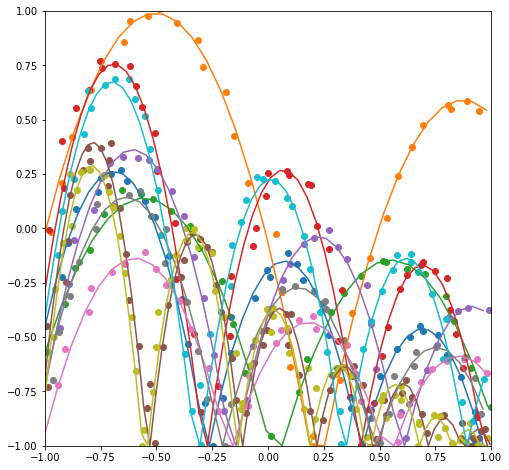

In [756]:
fig, ax = plt.subplots(figsize=(8,8))

for _ in range(10):
    idx = np.random.randint(len(df))

    ax.plot(df.loc[idx]['true trajectory'][:,0],df.loc[idx]['true trajectory'][:,1])
    ax.scatter(df.loc[idx]['measured trajectory'][:,0],df.loc[idx]['measured trajectory'][:,1])

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.show()

## step 1 - create a dataset object

this object will be able to load a single item from our dataset, and tell us the length of the dataset (the number of items).
if for example your dataset is too big to fit into memory at once, this is where you would get around that by loading only the relevant entry.

In [812]:
from torch.utils.data import Dataset, DataLoader

class MyCustomDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataframe):
        
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        sample_df = self.df.iloc[idx]
        sample = {
            'seq_length': sample_df['seq_length'],
            'true trajectory': sample_df['true trajectory'],
            'measured trajectory': sample_df['measured trajectory']
        }
        return sample

my_dataset = MyCustomDataset(df)

In [813]:
# the datset object can give us an item from our dataset by index
my_dataset[2]

{'seq_length': 80, 'true trajectory': array([[-1.      , -0.927322],
        [-0.976591, -0.694322],
        [-0.953182, -0.497322],
        [-0.929773, -0.336322],
        ...,
        [ 0.779096, -1.      ],
        [ 0.802505, -1.      ],
        [ 0.825914, -1.      ],
        [ 0.849323, -1.      ]]), 'measured trajectory': array([[-0.973927, -0.929305],
        [-0.976161, -0.71022 ],
        [-0.931792, -0.481889],
        [-0.968002, -0.296343],
        ...,
        [ 0.754563, -1.029922],
        [ 0.821505, -0.999366],
        [ 0.833494, -0.95462 ],
        [ 0.817945, -0.986883]])}

## in the special cases where our input data does not "stack" well, we need to create a custom "batch building" function

this function gets a list of items from the dataset object, and we must give back nice rectengular tensors containing the relevant parts. stick to a X,y format in the output.
in this case we need to pass to the neural net both the input sequence and the sequence lengths, so X is actually a tuple containing both objects

In [814]:
def create_batch(batch):
    
    lengths = [sample['seq_length'] for sample in batch]
    
    
    targets = [ torch.FloatTensor(sample['true trajectory']) for sample in batch]
    measured = [ torch.FloatTensor(sample['measured trajectory']) for sample in batch]
    
    max_length = np.max(lengths)
    n_sequences = len(measured)
    
    targets_tensor = torch.zeros((n_sequences,max_length,2)).float()
    measured_tensor = torch.zeros((n_sequences,max_length,2)).float()
    
    for i in range(n_sequences):
        seq_len = lengths[i]
        
        targets_tensor[i,:seq_len] = targets[i]
        measured_tensor[i,:seq_len] = measured[i]
    
    sequence_lengths = torch.LongTensor(lengths)
    sequence_lengths, perm_index = sequence_lengths.sort(0, descending=True)
    targets_tensor = targets_tensor[perm_index]
    measured_tensor = measured_tensor[perm_index]
                            
    return (measured_tensor,sequence_lengths), targets_tensor

## now we can create a dataloader object, which takes our dataset and our batching function

this object will create randomly shuffled batches every time we iterate over it, so we can use it in our training loop

In [815]:
dataset_loader = torch.utils.data.DataLoader(my_dataset,
                                             batch_size=3, shuffle=True,collate_fn=create_batch,
                                             num_workers=1)

In [816]:
for x,y in dataset_loader:
    print(x[0].shape,x[1])
    print('-------')
    break

torch.Size([3, 73, 2]) tensor([73, 44, 28])
-------


## now that we know how to batch variable size input (and output) let's build an RNN to predict the true trajectory from the measured trajectory

In [817]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        
        size_of_sequence_element = 2
        hidden_state_size = 10
        self.lstm = nn.LSTM(size_of_sequence_element,hidden_state_size,batch_first=True,
                            bidirectional=True,num_layers=2)
        
        output_size = 2
        self.linear = nn.Linear(2*hidden_state_size,output_size)
        
        
    def forward(self,x,sequence_lengths):

        packed_input = pack_padded_sequence(x,sequence_lengths.data.numpy(),batch_first=True)
        
        hidden_states, (final_hidden_state, cell_state) = self.lstm(packed_input)
        
        output,lengths = pad_packed_sequence( hidden_states , batch_first=True)
        
        output = self.linear(output)
        
        for sample_i in range(len(lengths)):
            seq_length = lengths[sample_i]
            output[sample_i][seq_length:,:] = 0
        
        
        return output


    
## we can do the training in "pytorch" style, by writing our own training loop



In [818]:
rnn = RNN()
loss_func = nn.MSELoss()
optimiser = torch.optim.Adam(rnn.parameters(),lr=0.001)
rnn.train()

batch_i = -1
for x,y in dataset_loader:
    batch_i+=1
    x,lengths = x
    optimiser.zero_grad()

    outputs = rnn(x,lengths)
    loss = loss_func(outputs,y)
    loss.backward()
    optimiser.step()
    if batch_i % 1000 == 0:
        print(loss)

tensor(0.3253, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0002, grad_fn=<MseLossBackward>)
tensor(0.0002, grad_fn=<MseLossBackward>)


## or we can use fastai, in order to do that, we need to wrap our dataset, batching function and model in a learner object.

In [804]:
import fastai
from fastai import *
from fastai.vision import *

In [805]:
rnn = RNN()

db = DataBunch.create(train_ds=my_dataset, 
                      valid_ds=my_dataset,
                      bs=10,num_workers=1,
                      collate_fn=create_batch)

learn = Learner(db,rnn,loss_func=nn.MSELoss())

In [511]:
learn.lr_find()
learn.recorder.plot()

In [512]:
learn.fit_one_cycle(1)

## let's test our model

In [819]:
%%capture
index_to_test = 48 # select an index from the test dataset

test_dataset = MyCustomDataset(test_df[index_to_test:index_to_test+1])

test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=1, shuffle=False,collate_fn=combine_samples,
                                             num_workers=1)


# switch the RNN to eval mode (to disable dropout)
rnn.eval()

itr = iter(test_loader)
x,y = itr.next()
x, lengths = x
predicted = rnn(x,lengths)
predicted = predicted[0].data.numpy()


traj, measured,_ = test_df.loc[index_to_test]

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)


line, = ax.plot([],[],lw=2,label='target')
scat = ax.scatter([],[],label='measured')
pred_line = ax.plot(predicted[:,0],predicted[:,1],label='predicted')
ax.legend()

def init():
    line.set_data([],[])
    scat.set_offsets(np.zeros((1,2)))
    return (line,scat,)

def animate(i):
    x = traj[:,0][:i]
    y = traj[:,1][:i]
    line.set_data(x,y)
    scat.set_offsets(measured[:i])
    
    return ( line,)

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=80,interval=30,blit=True)

In [820]:
HTML(anim.to_jshtml())

## looks good!

## now let's move on to a different task on this dataset, predicting the future of a trajectory based on the measured past.


In [831]:
chunk_df = pd.read_hdf('bouncing_ball_chunks.h5')
chunk_test_df = pd.read_hdf('bouncing_ball_chunks_test.h5')

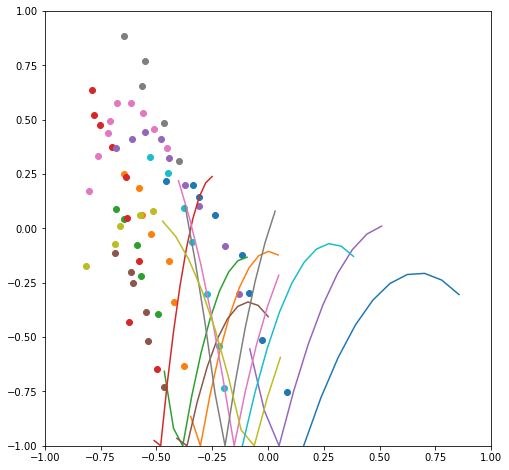

In [822]:
fig, ax = plt.subplots(figsize=(8,8))

for _ in range(10):
    idx = np.random.randint(len(chunk_df))

    ax.scatter(chunk_df.loc[idx]['input_arr'][:,0],chunk_df.loc[idx]['input_arr'][:,1])
    ax.plot(chunk_df.loc[idx]['target_arr'][:,0],chunk_df.loc[idx]['target_arr'][:,1])

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.show()

## again create a dataset object, a batching function, and a dataloader

In [823]:
class ChunksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataframe):
        
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        sample_df = self.df.iloc[idx]
        sample = {
            'seq_length': sample_df['seq_length'],
            'input_arr': sample_df['input_arr'],
            'target_arr': sample_df['target_arr']
        }
        return sample

c_dataset = ChunksDataset(chunk_df)

In [824]:
def create_batch(batch):
    
    lengths = [sample['seq_length'] for sample in batch]
    
    
    targets = [ torch.FloatTensor(sample['target_arr']) for sample in batch]
    measured = [ torch.FloatTensor(sample['input_arr']) for sample in batch]
    
    output_length = len(targets[0])
    
    max_length = np.max(lengths)
    n_sequences = len(measured)
    
    targets_tensor = torch.zeros((n_sequences,output_length,2)).float()
    measured_tensor = torch.zeros((n_sequences,max_length,2)).float()
    
    for i in range(n_sequences):
        seq_len = lengths[i]
        
        targets_tensor[i,:output_length] = targets[i]
        measured_tensor[i,:seq_len] = measured[i]
    
    sequence_lengths = torch.LongTensor(lengths)
    sequence_lengths, perm_index = sequence_lengths.sort(0, descending=True)
    targets_tensor = targets_tensor[perm_index]
    measured_tensor = measured_tensor[perm_index]
    
    return (measured_tensor,sequence_lengths), targets_tensor

In [825]:
dataset_loader = torch.utils.data.DataLoader(c_dataset,
                                             batch_size=3, shuffle=True,collate_fn=create_batch,
                                             num_workers=1)


for x,y in dataset_loader:
    print(x[0].shape,x[1])
    print('-------')
    break

torch.Size([3, 9, 2]) tensor([9, 9, 9])
-------


## the model is a little more complicated

there are two LSTMs, one for encoding the sequence and one for decoding,
notice how the decoder starts from the encoders final hidden state, and then extends the output sequence with it's own previous outputs

In [834]:
class SequenceRNN(nn.Module):
    def __init__(self):
        super(SequenceRNN,self).__init__()
        
        size_of_sequence_element = 2
        self.hidden_state_size = 15
        self.num_layers = 2
        
        self.encoder_lstm = nn.LSTM(size_of_sequence_element,self.hidden_state_size,
                                    batch_first=True,num_layers=self.num_layers,dropout=0.2)
        
        self.decoder_lstm = nn.LSTM(self.hidden_state_size,self.hidden_state_size,batch_first=True)
        
        output_size = 2
        self.linear = nn.Linear(self.hidden_state_size,output_size)
        
        
    def forward(self,x,sequence_lengths,outputsize = 10):
        
        batch_s = len(sequence_lengths)
        
        packed_input = pack_padded_sequence(x,sequence_lengths.data.numpy(),batch_first=True)
        hidden_states, (final_hidden_state, cell_state) = self.encoder_lstm(packed_input)
        
        # this is a little annoying, since i'm using the "batch first" option I need to 
        # permute the output to be batch first manually...
        
        final_hidden_state = final_hidden_state.permute(1,0,2)
        final_hidden_state = final_hidden_state[:,1,:]
        
        final_hidden_state = final_hidden_state.view(batch_s,1,self.hidden_state_size)
        
        _, (output_hidden_states,_) = self.decoder_lstm(final_hidden_state)
        
        decoder_sequence = output_hidden_states.permute(1,0,2)
        
        
        for output_i in range(outputsize-1):
            _, (output_hidden_states,_) = self.decoder_lstm(decoder_sequence)
            decoder_sequence = torch.cat([decoder_sequence,output_hidden_states.permute(1,0,2)],dim=1)


        output = self.linear(decoder_sequence)

        return output
    

## we train it in the same way

In [835]:
s_rnn = SequenceRNN()
db = DataBunch.create(train_ds=c_dataset, valid_ds=c_dataset,bs=10,num_workers=1,collate_fn=create_batch)
learn = Learner(db,s_rnn,loss_func=nn.MSELoss())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


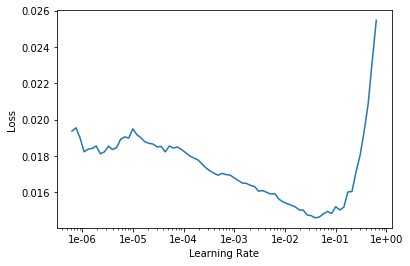

In [871]:
learn.lr_find()
learn.recorder.plot()

In [872]:
learn.fit(5,lr=1e-02)

## let's test it,

notice you can set the size of the predicted sequence to be more or less than the 10 it was trained on

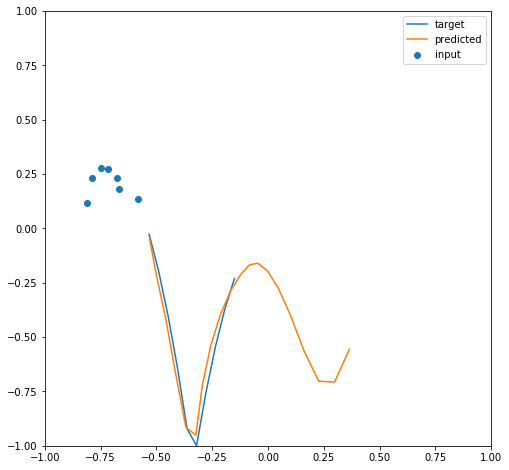

In [873]:
index_to_test = np.random.randint(len(chunk_test_df))


c_dataset_test = ChunksDataset(chunk_test_df[index_to_test:index_to_test+1])
dataset_loader = torch.utils.data.DataLoader(c_dataset_test,
                                             batch_size=1, shuffle=False,collate_fn=create_batch,
                                             num_workers=1)

itr = iter(dataset_loader)
x,y = itr.next()
x, lengths = x
predicted = s_rnn(x,lengths,20)
predicted = predicted[0].data.numpy()


fig, ax = plt.subplots(figsize=(8,8))


ax.scatter(chunk_test_df.loc[index_to_test]['input_arr'][:,0],chunk_test_df.loc[index_to_test]['input_arr'][:,1],label='input')
ax.plot(chunk_test_df.loc[index_to_test]['target_arr'][:,0],chunk_test_df.loc[index_to_test]['target_arr'][:,1],label='target')
ax.plot(predicted[:,0],predicted[:,1],label='predicted')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.legend()
plt.show()